In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

TypeError: can only concatenate str (not "list") to str

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

64111602.0


In [3]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [4]:
# Generate class with contact matrix for SIR-type model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

def contactMatrix(t):
    return CH + CW + CS + CO

In [5]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [6]:
beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([2]*M)
R0   = np.zeros(M)
S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
print(Ni)

Tf=100;  Nf=Tf+1 

data=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, generator.constant_CM, Tf, Nf)

[31268.886 35668.366 35526.088 25759.864]


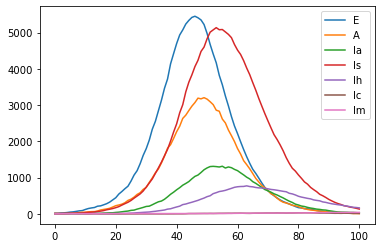

In [7]:
## Save pre intervention traj
data_array = data['X']

np.save('stoch_traj_SEAI5R.npy', data_array)

# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.legend()
plt.show()

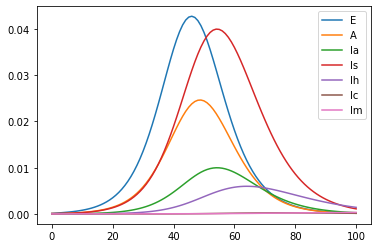

In [10]:
# load the data and rescale to intensive variables 
x = np.load('stoch_traj_SEAI5R.npy').astype('float')
x = x[:,:8*M]/N
steps = 101 # number internal integration steps taken

# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

det_model = pyross.deterministic.SEAI5R(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)

#plt.plot(x_det[:, 0], label='S')
plt.plot(x_det[:, M], label='E')
plt.plot(x_det[:, 2*M], label='A')
plt.plot(x_det[:, 3*M], label='Ia')
plt.plot(x_det[:, 4*M], label='Is')
plt.plot(x_det[:, 5*M], label='Ih')
plt.plot(x_det[:, 6*M], label='Ic')
plt.plot(x_det[:, 7*M], label='Im')
plt.legend()
plt.show()

In [11]:
x = data['X']
x = (x/N)[:,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
#print(logp) 
print(end_time - start_time)

#plt.plot(x[:, M])
#plt.show()

KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 513, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py", line 242, in odeint
    output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,
  File "pyross/inference.pyx", line 506, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "<__array_function__ internals>", line 2, in einsum
KeyboardInterrupt: 


51.0879020690918


In [ ]:
#### infer the parameters from the initial part of the trajectory

# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
obs=x ## up to intervention time
x0 = x[0]

## guesses for params
alpha_g = 0.4          
beta_g  = 0.03         
gIa_g   = 1./7            
gIs_g   = 1./7   
gE_g    = 1/5
gA_g    = 1/3

S0_g = S0/N
E0_g = E0/N
A0_g  = A0/N
Ia0_g = Ia0/N
Is0_g = Is0/N
Ih0_g = Ih0/N
Ic0_g = Ic0/N
Im0_g = Im0/N

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  


# set up bounds for the rest of the params 
alpha_b = (0.1,0.5)
beta_b  = (eps, 0.06)
gIa_b   = (eps, 0.2)
gIs_b   = (eps, 0.2)
gE_b    = (0.15, 0.25)
gA_b    = (0.3, 0.4)

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])
# stds of the model parameters' priors
stds = np.array([0.2*(k[1] - k[0]) for k in bounds])
stds[0] = 0.3 ## make one a bit larger for demonstration

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g])
params = estimator.inference(guess, stds, obs, Tf, Nf, generator.constant_CM, bounds=bounds, verbose=True, niter=2, ftol=ftol, eps=eps, global_max_iter=20)
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=406043, Fri May  1 08:43:22 2020)


In [ ]:
parameters = estimator.make_params_dict(params)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, generator.constant_CM)
x = data['X']/N

plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.plot(x[:,5*M], label='Ih')
plt.plot(x_det[:, 5*M])
plt.plot(x[:,6*M], label='Ic')
plt.plot(x_det[:, 6*M])
plt.plot(x[:,7*M], label='Im')
plt.plot(x_det[:, 7*M])
plt.legend()
plt.show()

plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()